## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [2]:
import Pkg


In [8]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [9]:
using DelimitedFiles


Load some packages to make nice figures

In [13]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes


The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [14]:
#3D points in space
Nx = 3 
Ny = 3


3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [15]:
Δtdyn = 0.05 #"ground truth" time step
Δtobs = 0.1 # observation time step


0.1

Define the time span of interest

In [16]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)


1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [19]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx)) #initial distribution, mean is the origin


FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [23]:
h(x, t) = x #deterministic part of observation model
F = StateSpace(lorenz63!, h) #combines the dynamic and observation models into one object

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [24]:
### Process and observation noise
σx = 1e-1
σy = 1e-3

ϵx = AdditiveInflation(Nx, zeros(Nx), σx) #process noise
ϵy = AdditiveInflation(Ny, zeros(Ny), σy) #observation noise

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6], [0.001 0.0 0.0; 0.0 0.001 0.0; 0.0 0.0 0.001])

In [26]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [27]:
# Number of runs/ensemble members
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Create cache to store the different final solutions

In [29]:
X = zeros(Ny + Nx, Ne); #joint samples

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [30]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [14]:
# writedlm( "lorenzdata.csv",  X, ',')
X = readdlm( "lorenzdata.csv",  ',')

6×500 Array{Float64,2}:
 12.6981    0.930478   3.98214  13.6515  …   5.38257    9.40037  -13.654
  8.37203   1.62649    5.75284  13.2089      0.775109   3.96774  -11.2277
 36.521    10.9611    17.4395   34.3492     29.3109    33.9116    36.3547
 12.6979    0.929687   3.98188  13.6506      5.38174    9.40014  -13.6549
  8.37175   1.62558    5.75274  13.2087      0.774492   3.96771  -11.2286
 36.5206   10.9604    17.4391   34.3489  …  29.3107    33.9112    36.354

In [32]:
# Initialize the map
m = 10
S = HermiteMap(m, X; diag = true, α = 1.0e-4)

HermiteMap(10, 6, LinearTransform(6, [0.44473129082540136, 0.7198137572129855, 23.772946446133272, 0.44424983739899576, 0.7193074613527211, 23.772456523227298], [8.03694827679235 0.0 … 0.0 0.0; 0.0 9.20781362939896 … 0.0 0.0; … ; 0.0 0.0 … 9.207809725124045 0.0; 0.0 0.0 … 0.0 8.515025921069848], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [34]:
Ne

500

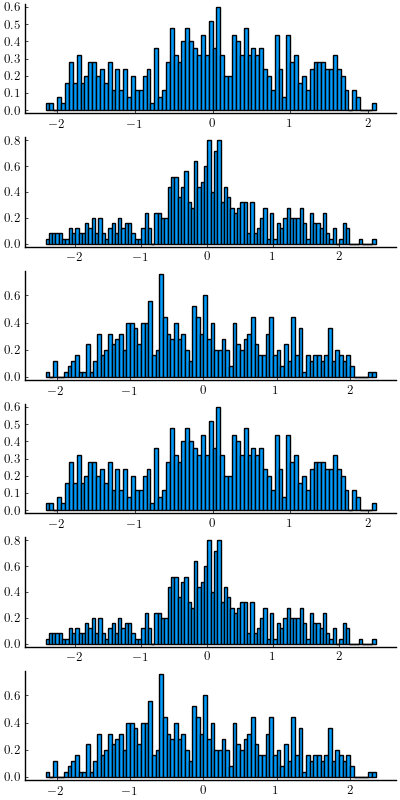

In [35]:
plt = plot(layout = grid(6,1), size = (400, 800))

for i=1:6
      histogram!(plt[i,1], sort(transform(X)[i,:]), bins = 100; normalize = :pdf, legend = false)     
end
plt
# savefig("normalized_histogram.pdf")

In [36]:
transform(X)

6×500 Array{Float64,2}:
  0.891015  -0.280037   0.428655  …  -1.11096   0.588473  -0.476276
  1.41205   -0.457562  -0.480062     -0.486938  0.317074   0.235845
 -1.26998   -1.62079    0.887121      1.01203   0.205296   0.731141
  0.891019  -0.279984   0.428652     -1.11094   0.588443  -0.476236
  1.41203   -0.457584  -0.480036     -0.486911  0.317033   0.235882
 -1.26998   -1.62079    0.887143  …   1.01209   0.205268   0.731126

In [38]:
getcoeff(S[3])

1-element Array{Float64,1}:
 0.0

The optimization works up to 22 active features, after the Cholesky decomposition crashes.

In [39]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = true, hessprecond = true)

1 terms - Training error: 1.432610609928614, Validation error: 1.3592502263089086
1 terms - Training error: 1.4325240985340038, Validation error: 1.3589131079813486
2 terms - Training error: 1.4239460696281776, Validation error: 1.3653127396137006
3 terms - Training error: 1.4187003036725083, Validation error: 1.3604842619179631
4 terms - Training error: 1.4095872957379902, Validation error: 1.346739172914098
5 terms - Training error: 1.4094473805741823, Validation error: 1.347644685259413
6 terms - Training error: 1.3425819702437003, Validation error: 1.272438895416159
7 terms - Training error: 1.3424968127986658, Validation error: 1.2704259675223246
8 terms - Training error: 1.3418176171719534, Validation error: 1.2715500534888036
9 terms - Training error: 1.3417641781715186, Validation error: 1.2727462997468946
1 terms - Training error: 1.4027623156351958, Validation error: 1.4786434034825817
1 terms - Training error: 1.4023908954841884, Validation error: 1.4796734674464393
2 terms 

Progress:  17%|██████▉                                  |  ETA: 0:00:20

7 terms - Training error: 1.3267682074231717
1 terms - Training error: 1.4236146661762275, Validation error: 1.3952340013184534
1 terms - Training error: 1.4230873737016123, Validation error: 1.3967369345242482
2 terms - Training error: 1.0572158504617728, Validation error: 1.0664544052176
3 terms - Training error: 1.0570811884205247, Validation error: 1.0651507821245978
4 terms - Training error: 1.0330039438648526, Validation error: 1.0417809315295292
5 terms - Training error: 1.0325916595638092, Validation error: 1.0428558212645676
6 terms - Training error: 0.7538931941878585, Validation error: 0.7578336275540177
7 terms - Training error: 0.7529727225144152, Validation error: 0.756036171745547
8 terms - Training error: 0.7102475824746974, Validation error: 0.7235299024203808
9 terms - Training error: 0.7054463807883119, Validation error: 0.727087688747506
1 terms - Training error: 1.4129566081434513, Validation error: 1.4378662334495602
1 terms - Training error: 1.412647713590693, Va

Progress:  33%|█████████████▋                           |  ETA: 0:00:09

5 terms - Training error: 1.0344177322458314
6 terms - Training error: 0.7540485159343787
7 terms - Training error: 0.7529767350717391
8 terms - Training error: 0.7121352145398258
9 terms - Training error: 0.7088077800606581
1 terms - Training error: 1.4242772389656226, Validation error: 1.3925837101608722
1 terms - Training error: 1.4152518619324688, Validation error: 1.3760323141765347
2 terms - Training error: 1.1377332730761587, Validation error: 1.12649819146525
3 terms - Training error: 1.0203039793068962, Validation error: 1.0635760726361427
4 terms - Training error: 0.8314236869449502, Validation error: 0.9269267665909329
5 terms - Training error: 0.8010319788328916, Validation error: 0.8981990955602099
6 terms - Training error: 0.38396021013133563, Validation error: 0.46994660994726706
7 terms - Training error: 0.38237153682016267, Validation error: 0.4663384251060235
8 terms - Training error: 0.372478442182434, Validation error: 0.4305933389365219
9 terms - Training error: 0.

Progress:  50%|████████████████████▌                    |  ETA: 0:00:05

6 terms - Training error: 0.40049224148333673
7 terms - Training error: 0.3985173860101243
8 terms - Training error: 0.38305286616642326
9 terms - Training error: 0.3792906586390234
10 terms - Training error: 0.3736063990294901
1 terms - Training error: 1.4326114864614607, Validation error: 1.3592467201775218
1 terms - Training error: 1.4323552306231102, Validation error: 1.3587042659862865
2 terms - Training error: 0.9519946455501272, Validation error: 0.941481295178374
3 terms - Training error: 0.9512324711531488, Validation error: 0.9399134158684634
4 terms - Training error: 0.919604940889511, Validation error: 0.9193193052856669
5 terms - Training error: 0.9182875798931897, Validation error: 0.9163136719712613
6 terms - Training error: -0.473997983565764, Validation error: -0.8442877025465559
7 terms - Training error: -0.5577149762332576, Validation error: -1.002311790940932
8 terms - Training error: -3.417402296695751, Validation error: -3.472213669836731
9 terms - Training error:

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

8 terms - Training error: -3.4287686199754495
9 terms - Training error: -3.4287945829416198
10 terms - Training error: -3.4336950620417244
1 terms - Training error: 1.4236153643892016, Validation error: 1.3952312084665568
1 terms - Training error: 1.4230880730269058, Validation error: 1.3967341226727072
2 terms - Training error: 1.0572168029660127, Validation error: 1.0664529289460156
3 terms - Training error: 1.0570821401616042, Validation error: 1.06514926914505
4 terms - Training error: 1.0330052625686534, Validation error: 1.0417805317545787
5 terms - Training error: 1.0325929621989516, Validation error: 1.042855532208457
6 terms - Training error: 0.753897783789708, Validation error: 0.7578371279443677
7 terms - Training error: 0.7530823429373193, Validation error: 0.7567379400746326
8 terms - Training error: -0.23454514985404884, Validation error: -0.2797714538648006
9 terms - Training error: -0.24425687163618445, Validation error: -0.27616464970671484
1 terms - Training error: 1.

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

10 terms - Training error: 0.7093076000391453
1 terms - Training error: 1.4242773607251793, Validation error: 1.3925832231226452
1 terms - Training error: 1.4152519106922599, Validation error: 1.3760320506362753
2 terms - Training error: 1.1377329581990643, Validation error: 1.1264915372803945
3 terms - Training error: 0.9706283382597434, Validation error: 0.9747562559450281
4 terms - Training error: 0.9362313160343357, Validation error: 0.9340779536899037
5 terms - Training error: 0.9351917116503181, Validation error: 0.9336245060068222
6 terms - Training error: 0.9200371761199252, Validation error: 0.9195790351580526
7 terms - Training error: 0.9184048160218573, Validation error: 0.9089692224273221
8 terms - Training error: -0.5452105980212709, Validation error: -0.7951318557505052
9 terms - Training error: -0.5459744458052133, Validation error: -0.7942819888780019
1 terms - Training error: 1.3945308930579439, Validation error: 1.5115690937915878
1 terms - Training error: 1.387223259

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


8 terms - Training error: -0.5987045601194573
9 terms - Training error: -0.5991407466398974
10 terms - Training error: -0.7158203908485145
 28.366581 seconds (73.24 M allocations: 6.698 GiB, 5.03% gc time)


HermiteMap(10, 6, LinearTransform(6, [0.44473129082540136, 0.7198137572129855, 23.772946446133272, 0.44424983739899576, 0.7193074613527211, 23.772456523227298], [8.03694827679235 0.0 … 0.0 0.0; 0.0 9.20781362939896 … 0.0 0.0; … ; 0.0 0.0 … 9.207809725124045 0.0; 0.0 0.0 … 0.0 8.515025921069848], true), MapComponent[Map component of dimension 1 with Nψ 7 active features
, Map component of dimension 2 with Nψ 9 active features
, Map component of dimension 3 with Nψ 10 active features
, Map component of dimension 4 with Nψ 10 active features
, Map component of dimension 5 with Nψ 10 active features
, Map component of dimension 6 with Nψ 10 active features
])

In [44]:
# Conditioning number of the basis evaluation on the different samples
cond(evaluate_basis(S[1].I.f.f,  transform(X[1:1,:])))

88.70333277572662

In [41]:
sign.([-1.0;2.0; 0.0; 3.0])

4-element Array{Float64,1}:
 -1.0
  1.0
  0.0
  1.0

In [45]:
stor = Storage(S[1].I.f, transform(X[1:1,:]))
q = QRscaling(stor)

QRscaling([-22.360679774997894 -1.0821908874452222 … -1.8638312383067885 2.1219878808790935; 0.0 22.33447700043882 … 7.4988364072686124 1.6987448533366203; … ; 0.0 0.0 … 3.331409546479707 -0.3110792123954399; 0.0 0.0 … 0.0 1.4262013217975553], [-0.0447213595499958 -0.0021669210243076627 … 0.02026328416870891 0.294275554847424; 0.0 0.04477382658122473 … 0.2881453674718176 0.07625898486825916; … ; 0.0 0.0 … 0.30017324080033864 0.0654729833041136; 0.0 0.0 … 0.0 0.7011632822914652], [0.522238041179522 0.0 … 0.0 0.0; 0.0 0.393833039785888 … 0.0 0.0; … ; 0.0 0.0 … 0.24819811539607292 0.0; 0.0 0.0 … 0.0 0.25523529073595885], [1.9148356135478168 0.0 … 0.0 0.0; 0.0 2.5391470470422233 … 0.0 0.0; … ; 0.0 0.0 … 4.029039456662298 0.0; 0.0 0.0 … 0.0 3.9179534974044827], [-11.677597605137455 -0.4262025268311396 … -0.4625994007640738 0.5416061937143567; 0.0 8.796054969110823 … 1.861197063947528 0.4335796365275861; … ; 0.0 0.0 … 0.8268495710487493 -0.07939839321766319; 0.0 0.0 … 0.0 0.36401690901700784

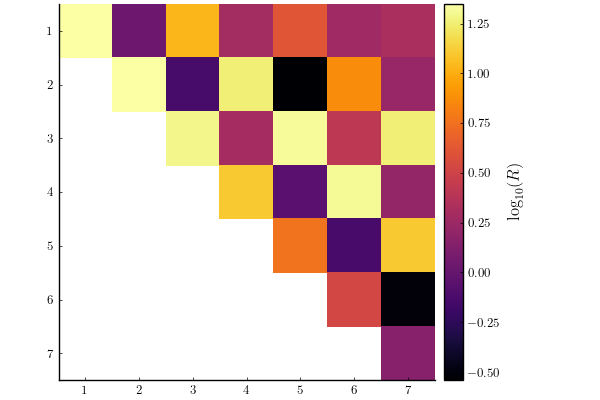

In [46]:
heatmap(log10.(abs.(q.R)), yflip =true, ratio = 1, colorbartitle = L"\log_{10}(R)")
# savefig("R_matrix.pdf")

In [47]:
cond(q.R)

77.78082627314554

In [48]:
getcoeff(S[3])

10-element Array{Float64,1}:
  32.51105882993062
 -18.69672660919596
 -13.56090780718974
  10.564117524173593
  -2.0067063963718903
   6.744544348706691
  -0.9050345522107038
   0.9325270462883335
   2.576177875541611
  -2.537766688473315

In [49]:
cond(evaluate_basis(S[6].I.f.f, X[1:6,:]))

4.574823162368109e12

In [50]:
P = zeros(ncoeff(S[1]), ncoeff(S[1]))
precond!(P, getcoeff(S[1]), stor, S[1], X[1:1,:])

Pqr = zeros(ncoeff(S[1]), ncoeff(S[1]))
qrprecond!(Pqr, q.U*getcoeff(S[1]), q, stor, S[1], X[1:1,:])

7×7 Array{Float64,2}:
  0.000787316   7.61998e-7    0.000394065  …  -0.000966229  -0.0353462
  7.61998e-7    0.000459073  -0.000101139     -0.0103273     0.00479452
  0.000394065  -0.000101139   0.00076143       0.00650028   -0.0286739
 -0.00024202   -0.00110674    0.000554833      0.0738137     0.0333796
 -0.00582439    0.000266976  -0.00365685       0.034416      0.697129
 -0.000966229  -0.0103273     0.00650028   …   0.717397      0.0662043
 -0.0353462     0.00479452   -0.0286739        0.0662043     4.64762

In [42]:
cond(P)

61.5983032653512

In [43]:
cond(Pqr)

31758.93211495225

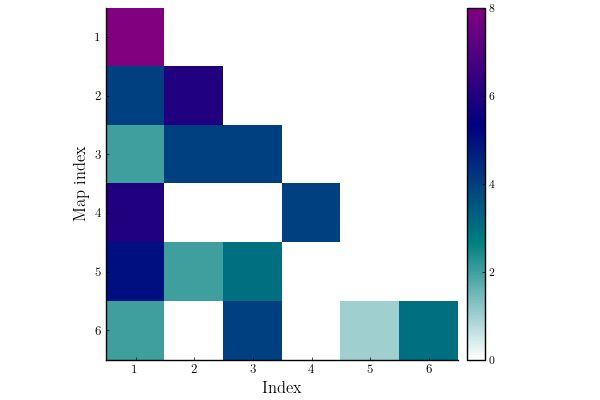

In [44]:
plot(S)

In [51]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
    2.78173e13      9.0288e7   …    716.808      4636.75
    9.0288e7        4.87369e7         0.0           0.0
    2.56274e5   41503.2           21269.3           1.03282e10
    2.76214e13      0.0               1.03028e6     0.0
  716.808           0.0               1.68442e6  9711.03
 4636.75            0.0        …   9711.03          1.07049e10

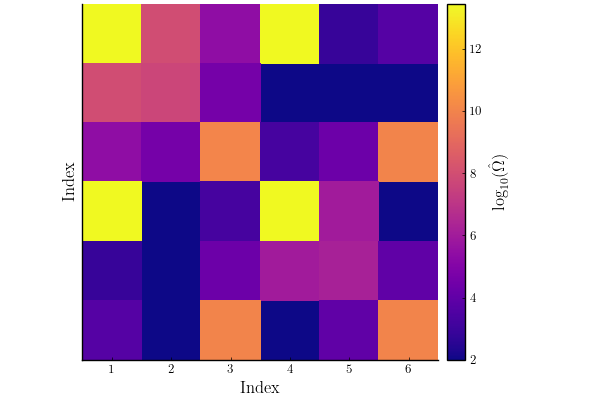

In [52]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

Set initial condition of the true system

In [53]:
x0 = rand(model.π0);

In [55]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [56]:
Ne = 500 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state (ensemble).
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 0.296368  -0.105481  -1.16144   …  0.710301   0.926892   -0.450892
 1.37527    1.72436   -1.47446      0.303214  -1.409      -0.634042
 1.32249    1.74407    0.281319     0.431843  -0.0383558  -0.495254

In [57]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, 2*Δtobs, false)

Stochastic Map Filter with filtered = false


In [60]:
Xsmf = seqassim(F, data, 200, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

t = 0.1
getcoeff(M[6]) = [4.159797723746049, -3.4526678296966233, -3.204227930151605, -25.202159227782698, -1.8938893065403914, -3.7086848473476746, 2.4513492662140592, 22.26184454351894, -0.06492991240054735, 1.554862077983909]


LoadError: DomainError with 0.5:
integrand produced NaN in the interval (0.0, 1.0)

In [206]:
nb = 1
ne = 100
Δ = 1

1

In [202]:
data.xt

3×1000 Array{Float64,2}:
 2.19995    6.69494  17.0328  15.0845   …  -2.16126  -3.73518   -7.39222
 4.48947   14.1139   27.3883   0.19421     -3.02302  -6.17331  -12.6411
 0.767393   4.11424  27.2119  46.6231      16.6741   14.0126    15.3754

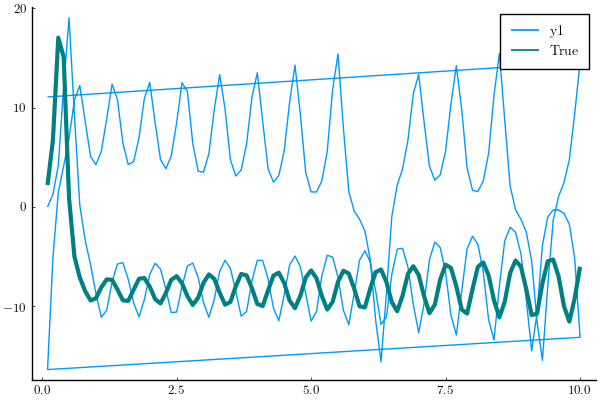

In [207]:
plot(data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,:])
plot!(data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")

In [94]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×201 Array{Float64,2} at index [1, 2:1:500][39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.